# Result analysis

In [26]:
from dotenv import load_dotenv
import os

# Get the path to the root directory of the repository
root_dir = os.path.abspath(os.path.join(os.getcwd(), '../..'))

# Load environment variables from .env file in the root directory
load_dotenv(os.path.join(root_dir, '.env'))

True

## Import data

In [27]:
RESULTS_DIR = os.environ.get("RESULTS_PATH")
EXPERIMENT_DIR = None
print(f"The results are stored in the directory {RESULTS_DIR}")

The results are stored in the directory /home/vm-kubernetes/SRE-agent/Results


In [28]:
experiment_batches = [d for d in os.listdir(RESULTS_DIR) if os.path.isdir(os.path.join(RESULTS_DIR, d))]

for i, dir in enumerate(experiment_batches, 1):
    print(f"{i}) {dir}")

1) 20251119-plain-ReAct
2) hotel-res-full-set


In [29]:
experiment_id = input("Choose the experiment ID (the number)")

try:
    id = int(experiment_id) - 1
    if id < 0 or id >= len(experiment_batches):
        print(f"Error: Invalid experiment ID. Please choose a number between 1 and {len(experiment_batches)}")
        id = 0
        print(f"Using first experiment: {experiment_batches[id]}") 
except ValueError:
    print(f"Error: Invalid input. Please enter a number between 1 and {len(experiment_batches)}")
    id = 0
    print(f"Using first experiment: {experiment_batches[id]}")

exp_folder_name = experiment_batches[id]
EXPERIMENT_DIR = os.path.join(RESULTS_DIR,exp_folder_name)

print(f"The experiment batch selected is {EXPERIMENT_DIR}")

The experiment batch selected is /home/vm-kubernetes/SRE-agent/Results/hotel-res-full-set


In [30]:
exp_results_files = [f for f in os.listdir(EXPERIMENT_DIR) if f.endswith('.json')]
print(f"Found {len(exp_results_files)} experiments:")
for file in exp_results_files:
    print(f"  - {file}")

Found 21 experiments:
  - 2025-11-20_12-53-19_Plain-React-P2-B7---Hotel-Reservation---Container-Kill-(hotel-res-full-set).json
  - 2025-11-20_14-55-39_B---Plain-React-P3-B7---Hotel-Reservation---No-fault-(hotel-res-full-set).json
  - 2025-11-20_14-49-18_C---Plain-React-P5-B7---Hotel-Reservation---Network-loss-(hotel-res-full-set).json
  - 2025-11-20_15-20-02_B---Plain-React-P3-B7---Hotel-Reservation---Pod-failure-(hotel-res-full-set).json
  - 2025-11-20_13-14-48_Plain-React-P5-B7---Hotel-Reservation---Container-Kill-(hotel-res-full-set).json
  - 2025-11-20_14-56-29_C---Plain-React-P5-B7---Hotel-Reservation---No-fault-(hotel-res-full-set).json
  - 2025-11-20_13-30-40_Plain-React-P3-B7---Hotel-Reservation---Port-missmatch-geo-(hotel-res-full-set).json
  - 2025-11-20_14-17-48_Plain-React-P5-B7---Hotel-Reservation---Network-delay-(hotel-res-full-set).json
  - 2025-11-20_15-12-28_A---Plain-React-P2-B7---Hotel-Reservation---Pod-failure-(hotel-res-full-set).json
  - 2025-11-20_13-52-34_Plain-

In [31]:
import json

experiment = exp_results_files[0]
with open(os.path.join(EXPERIMENT_DIR,experiment), 'r') as file:
    data = json.load(file)

In [32]:
def print_nested_keys(d, indent=0):
    for key in d.keys():
        print("  " * indent + str(key))
        if isinstance(d[key], dict):
            print_nested_keys(d[key], indent + 1)

print_nested_keys(data)


app_name
app_summary
target_namespace
trace_service_starting_point
problematic_pods
  problematic_pods
  info
slow_traces
  service
  traces
  info
problematic_metrics
  problematic_metrics
  info
problematic_traces
  service
  traces
  traces_count
symptoms
rca_tasks
rca_analyses_list
tasks_to_be_executed
final_report
  root_cause
  affected_resources
  evidence_summary
  investigation_summary
  detection
  localization
experiment_name
agent_configuration_name
stats
  run_id
  experiment_name
  status
  execution_time_seconds
  total_tokens
  total_cost
  langsmith_url
  agent_stats
    supervisor_agent
      total_tokens
      input_tokens
      output_tokens
      cost
      runs_count
    rca_agent
      total_tokens
      input_tokens
      output_tokens
      cost
      runs_count
    schedule_rca_tasks
      total_tokens
      input_tokens
      output_tokens
      cost
      runs_count
    planner_agent
      total_tokens
      input_tokens
      output_tokens
      cost
      

In [33]:
import pandas as pd
import json

experiments_df = pd.DataFrame()

for experiment in exp_results_files:
    try:
        with open(os.path.join(EXPERIMENT_DIR, experiment), 'r') as file:
            data = json.load(file)

            localization = data.get("final_report", {}).get("localization", [])
            if isinstance(localization, list):
                localization_str = ", ".join(localization)
            else:
                localization_str = None
    
        record = {
            "experiment_file": experiment,
            "scenario": data.get("app_name", "N/A"),
            "fault_name": data.get("testbed", {}).get("fault_name", "N/A"),
            "target_namespace": data.get("target_namespace", "N/A"),
            "trace_service_starting_point": data.get("trace_service_starting_point", "N/A"),
            "rca_tasks_per_iteration": data.get("testbed", {}).get("rca_tasks_per_iteration", 0),
            "max_tool_calls": data.get("testbed", {}).get("max_tool_calls", 0),
            "execution_time_seconds": data.get("stats", {}).get("execution_time_seconds", 0),
            "total_tokens": data.get("stats", {}).get("total_tokens", 0),
            "tokens_triage": data.get("stats", {}).get("agent_stats", {}).get("triage_agent", {}).get("total_tokens", 0),
            "tokens_planner": data.get("stats", {}).get("agent_stats", {}).get("planner_agent", {}).get("total_tokens", 0),
            "tokens_rca_worker": data.get("stats", {}).get("agent_stats", {}).get("rca_agent", {}).get("total_tokens", 0),
            "runs_count_rca": data.get("stats", {}).get("agent_stats", {}).get("rca_agent", {}).get("runs_count", 0),
            "tokens_supervisor": data.get("stats", {}).get("agent_stats", {}).get("supervisor_agent", {}).get("total_tokens", 0),
            "runs_count_supervisor": data.get("stats", {}).get("agent_stats", {}).get("supervisor_agent", {}).get("runs_count", 0),
            "detection": data.get("final_report", {}).get("detection", "N/A"),
            "localization": localization_str,
            "root_cause": data.get("final_report", {}).get("root_cause", "N/A"),
        }
        
        # Append record to dataframe
        experiments_df = pd.concat([experiments_df, pd.DataFrame([record])], ignore_index=True)
    
    except (json.JSONDecodeError, KeyError) as e:
        print(f"Warning: Error processing {experiment}: {str(e)}")
        continue

In [34]:
experiments_df

,experiment_file,scenario,fault_name,target_namespace,trace_service_starting_point,rca_tasks_per_iteration,max_tool_calls,execution_time_seconds,total_tokens,tokens_triage,tokens_planner,tokens_rca_worker,runs_count_rca,tokens_supervisor,runs_count_supervisor,detection,localization,root_cause
0,2025-11-20_12-53-19_Plain-React-P2-B7---Hotel-...,Hotel Reservation,Container Kill,test-hotel-reservation,frontend,2,7,356.189142,69629,3674,4593,56207,2,5155,1,True,frontend,The frontend is misconfigured: it does not hav...
1,2025-11-20_14-55-39_B---Plain-React-P3-B7---Ho...,Hotel Reservation,No fault,test-hotel-reservation,frontend,3,7,6.000688,703,703,0,0,0,0,1,False,None,No analysis data available
2,2025-11-20_14-49-18_C---Plain-React-P5-B7---Ho...,Hotel Reservation,Network loss,test-hotel-reservation,frontend,5,7,991.011532,102371,1368,4166,88441,5,8396,1,True,frontend-69d95967fb-vxf4p,A blocking operation (sleep/event-loop/thread ...
3,2025-11-20_15-20-02_B---Plain-React-P3-B7---Ho...,Hotel Reservation,Pod failure,test-hotel-reservation,frontend,3,7,391.669170,75271,1250,4040,63729,3,6252,1,True,user-8477d787d8-2nhtl,A pod-level command/entrypoint misconfiguratio...
4,2025-11-20_13-14-48_Plain-React-P5-B7---Hotel-...,Hotel Reservation,Container Kill,test-hotel-reservation,frontend,5,7,849.525262,141049,3369,4564,124048,5,9068,1,True,frontend,Misconfiguration in the frontend: the frontend...
5,2025-11-20_14-56-29_C---Plain-React-P5-B7---Ho...,Hotel Reservation,No fault,test-hotel-reservation,frontend,5,7,7.403968,703,703,0,0,0,0,1,False,None,No analysis data available
6,2025-11-20_13-30-40_Plain-React-P3-B7---Hotel-...,Hotel Reservation,Port missmatch geo,test-hotel-reservation,frontend,3,7,306.377005,58557,1209,3723,47643,3,5982,1,True,geo-6b4b89b5f5-666sz,The geo service (hotel-reserv-geo) crashed bec...
7,2025-11-20_14-17-48_Plain-React-P5-B7---Hotel-...,Hotel Reservation,Network delay,test-hotel-reservation,frontend,5,7,862.630168,157919,1119,4057,144480,4,8263,1,True,user-8477d787d8-nn6t8,Application-level configuration error in the u...
8,2025-11-20_15-12-28_A---Plain-React-P2-B7---Ho...,Hotel Reservation,Pod failure,test-hotel-reservation,frontend,2,7,279.872183,42950,1242,3460,33309,2,4939,1,True,deployment/user,The user Deployment's Pod template overrides t...
9,2025-11-20_13-52-34_Plain-React-P2-B7---Hotel-...,Hotel Reservation,Network delay,test-hotel-reservation,frontend,2,7,491.004181,89073,3317,4739,74541,2,6476,1,True,search-65df96d8df-5tbjb,The Search pod (search-65df96d8df-5tbjb) was m...


## Data exploration

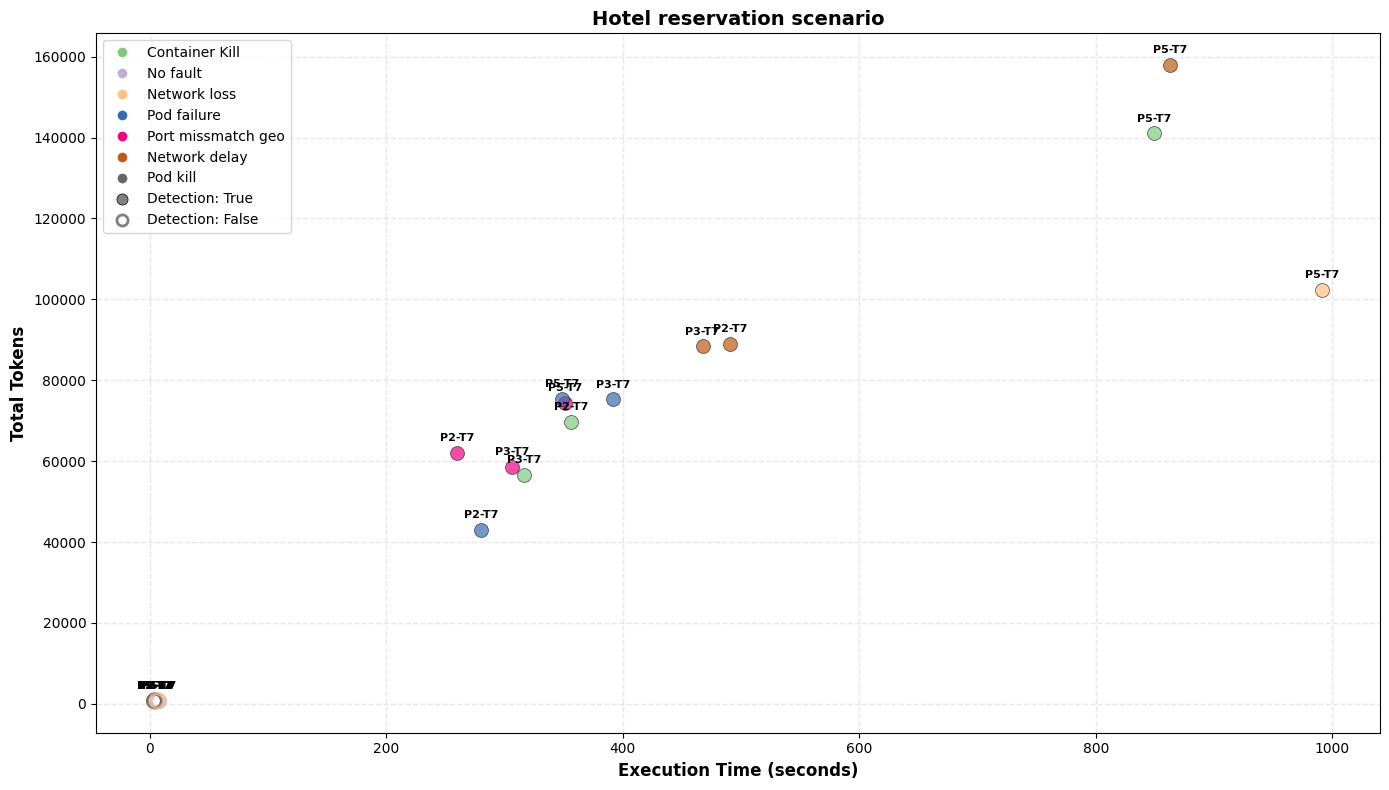

In [35]:
import matplotlib.pyplot as plt
import numpy as np

# Create figure and axis
fig, ax = plt.subplots(figsize=(14, 8))

# Get unique fault types for coloring
fault_types = experiments_df['fault_name'].unique()
colors = plt.cm.Accent(np.linspace(0, 1, len(fault_types)))
color_map = {fault: colors[i] for i, fault in enumerate(fault_types)}

# Plot each experiment as a dot
for idx, row in experiments_df.iterrows():
    x = row['execution_time_seconds']
    y = row['total_tokens']
    fault = row['fault_name']
    color = color_map[fault]
    detection = row['detection']
    
    # Plot the dot - filled if detection is True, only border if False
    if detection:
        ax.scatter(x, y, s=100, color=color, alpha=0.7, edgecolors='black', linewidth=0.5)
    else:
        ax.scatter(x, y, s=100, facecolors='none', edgecolors=color, linewidth=2, alpha=0.7)
    
    # Add label with agent configuration on top of the dot
    label = f"P{int(row['rca_tasks_per_iteration'])}-T{int(row['max_tool_calls'])}"
    ax.annotate(label, (x, y), fontsize=8, ha='center', va='bottom', fontweight='bold', 
                xytext=(0, 7), textcoords='offset points')

# Create legend for fault types
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_map[fault], 
                       markersize=8, label=fault) for fault in fault_types]

# Add detection legend
detection_handles = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', 
               markersize=8, label='Detection: True', markeredgecolor='black', markeredgewidth=0.5),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='none', 
               markersize=8, label='Detection: False', markeredgecolor='gray', markeredgewidth=2)
]

# Combine all handles into a single legend
all_handles = handles + detection_handles
ax.legend(handles=all_handles, loc='upper left', fontsize=10)

# Labels and title
ax.set_xlabel('Execution Time (seconds)', fontsize=12, fontweight='bold')
ax.set_ylabel('Total Tokens', fontsize=12, fontweight='bold')
ax.set_title('Hotel reservation scenario', fontsize=14, fontweight='bold')

# Grid
ax.grid(True, alpha=0.3, linestyle='--', linewidth=1)

plt.tight_layout()
plt.show()


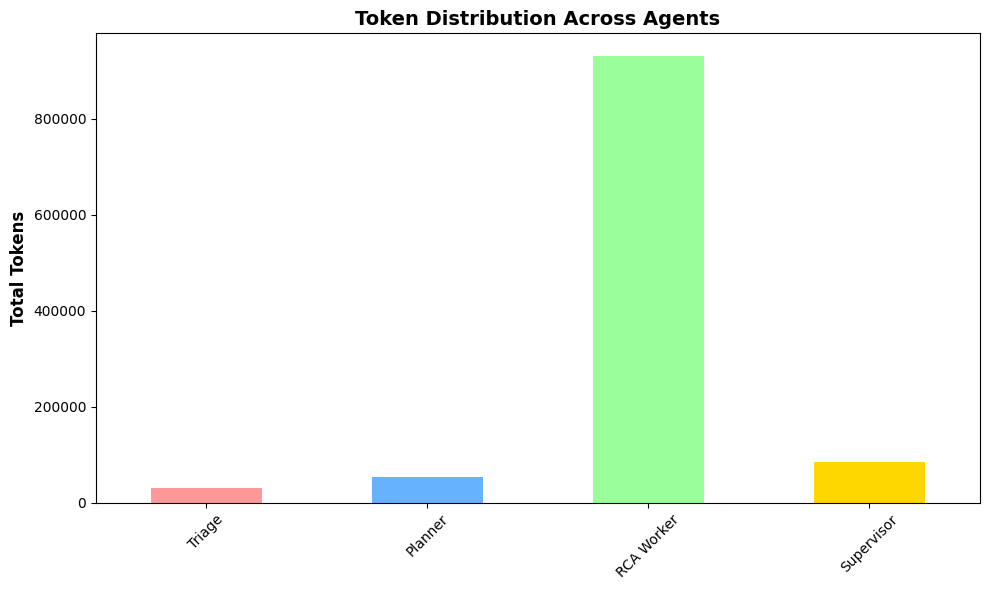

In [36]:
agent_tokens = experiments_df[[
    'tokens_triage',
    'tokens_planner', 
    'tokens_rca_worker',
    'tokens_supervisor'
]].sum()

fig, ax = plt.subplots(figsize=(10, 6))
agent_tokens.plot(kind='bar', ax=ax, color=['#FF9999', '#66B2FF', '#99FF99', '#FFD700'])
ax.set_ylabel('Total Tokens', fontsize=12, fontweight='bold')
ax.set_title('Token Distribution Across Agents', fontsize=14, fontweight='bold')
ax.set_xticklabels(['Triage', 'Planner', 'RCA Worker', 'Supervisor'], rotation=45)
plt.tight_layout()
plt.show()

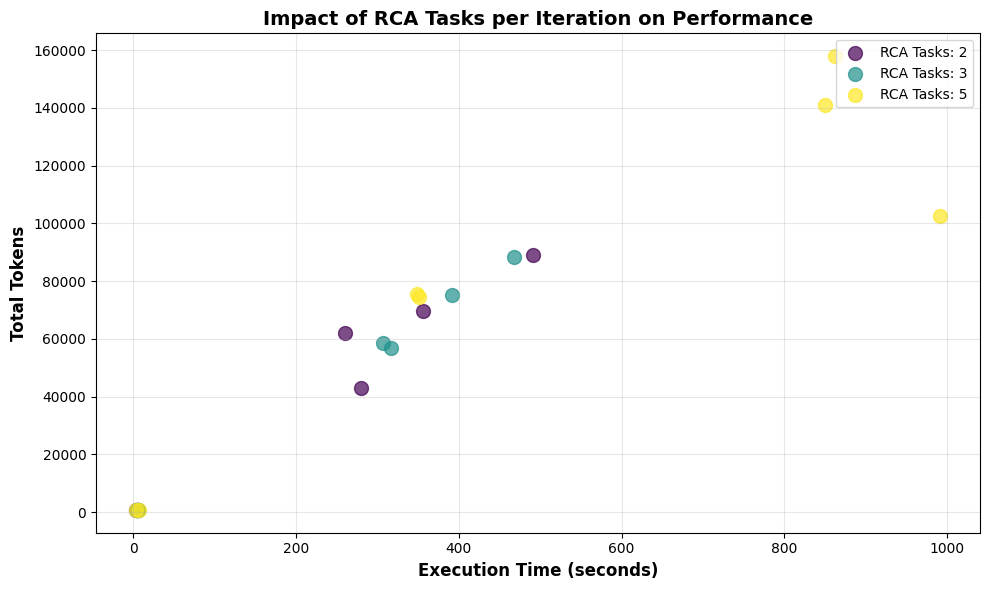

In [37]:
fig, ax = plt.subplots(figsize=(10, 6))
iterations = experiments_df['rca_tasks_per_iteration'].unique()
colors = plt.cm.viridis(np.linspace(0, 1, len(iterations)))

for i, iter_val in enumerate(sorted(iterations)):
    mask = experiments_df['rca_tasks_per_iteration'] == iter_val
    ax.scatter(experiments_df[mask]['execution_time_seconds'], 
              experiments_df[mask]['total_tokens'],
              label=f'RCA Tasks: {int(iter_val)}',
              s=100, alpha=0.7, color=colors[i])

ax.set_xlabel('Execution Time (seconds)', fontsize=12, fontweight='bold')
ax.set_ylabel('Total Tokens', fontsize=12, fontweight='bold')
ax.set_title('Impact of RCA Tasks per Iteration on Performance', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()